In [1]:
import polars as pl
from typing import Literal

def seasonal_decomposition(
    df: pl.DataFrame,
    id_col: str,
    target_col: str,
    time_col: str,
    freq: int,
    method: Literal['additive', 'multiplicative'] = 'additive'
) -> pl.DataFrame:
    """
    Perform seasonal decomposition of time series data using either an additive or multiplicative method.
    
    Parameters:
    - df: Polars DataFrame containing the time series data.
    - id_col: The column to group by (e.g., for multiple time series).
    - target_col: The column containing the time series values to decompose.
    - time_col: The column containing the time values.
    - freq: The seasonal period (e.g., 12 for monthly data with yearly seasonality).
    - method: The decomposition method ('additive' or 'multiplicative').
    ADDITIVE = Y(t) = T(t) + S(t) + E(t) 
    MULTIPLICATIVE = Y(t) = T(t) * S(t) * E(t)
    
    Returns:
    - Polars DataFrame with the decomposed components: trend, seasonal component, and residuals.
    """
    # Add the row index and period index
    df = (df.with_columns(
        pl.col(time_col).cum_count().over(id_col).alias('row_nr')
    )
    .with_columns( # create period idx based on frequency for each unique id 
        pl.col('row_nr').mod(freq).over(id_col).alias('period_idx')
        )
    ) 
    
    # Trend: Rolling mean with window size = freq
    trend_expr = (pl.col(target_col)
                  .rolling_mean(window_size=freq, 
                                center=True)
                  .over(id_col)
                  .alias('trend'))
    
    # Seasonal component (additive method)
    seasonal_component_expr = (pl.col(target_col)
                               .sub(pl.col('trend'))
                               .mean()
                               .over(id_col, 'period_idx')
                               .alias('seasonal_idx'))

    # Adjust seasonal component to have mean = 0 (for additive)
    seasonal_idx_expr = (pl.col('seasonal_idx')
                         .sub(pl.col('seasonal_idx').mean().over(id_col))
                         .alias(f'seasonal_{freq}'))

    # Residuals: Original series - trend - seasonal components (additive)
    residuals_expr = (pl.col(target_col)
                      .sub(pl.col('trend'))
                      .sub(pl.col(f'seasonal_{freq}'))
                      .alias('resid'))

    # Apply decomposition method
    if method == 'additive':
        # For additive decomposition, residuals are the original minus trend and seasonal component
        series = (df
                  .with_columns(trend_expr)
        .with_columns(seasonal_component_expr)

        .with_columns(seasonal_idx_expr)

        .with_columns(residuals_expr)
        
        .select(id_col,time_col,target_col,'trend',f'seasonal_{freq}','resid')

        #drop nulls created by centered moving average 
        .drop_nulls()
    
        )
    elif method == 'multiplicative':
        # For multiplicative decomposition, residuals are the original divided by trend and seasonal component
        seasonal_component_expr = (pl.col(target_col)
                                   .truediv(pl.col('trend'))
                                   .mean()
                                   .over(id_col, 'period_idx')
                                   .alias('seasonal_idx'))

        seasonal_idx_expr = (pl.col('seasonal_idx')
                             .sub(pl.col('seasonal_idx').mean().over(id_col))
                             .alias(f'seasonal_{freq}'))

        residuals_expr = (pl.col(target_col)
                          .truediv(pl.col('trend'))
                          .truediv(pl.col(f'seasonal_{freq}'))
                          .alias('resid'))

        # Apply multiplicative method
        series =  (df
                   .with_columns(trend_expr)
        .with_columns(seasonal_component_expr)

        .with_columns(seasonal_idx_expr)

        .with_columns(residuals_expr)

        .select(id_col,time_col,target_col,'trend',f'seasonal_{freq}','resid')
        
        #drop nulls created by centered moving average 
        .drop_nulls()
        )
    
    return series

In [5]:
import polars as pl 
from typing import Literal


df = pl.scan_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet').collect()

# Call the seasonal_decomposition function
decomposed_df = seasonal_decomposition(
    df,
    id_col='unique_id',    # Group by store
    target_col='y',   # Decompose the sales column
    time_col='ds',      # The time column (in this case, date)
    freq=24,              # specify this as the frequency of your data, so hourly frequency with daily seasonality.... 
    method='additive'     # You can also try 'multiplicative'
)


<Axes: xlabel='ds'>

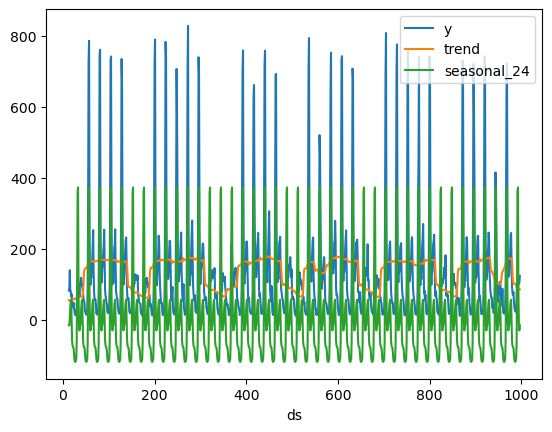

In [10]:
decomposed_df.filter(pl.col('unique_id').eq(pl.col('unique_id').sample(1))).to_pandas().plot(x='ds',y=['y','trend','seasonal_24'])